In [992]:
#imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#nlp imports
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import spacy


from multiprocessing import dummy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import BaggingClassifier,StackingClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier
from sklearn.dummy import DummyClassifier

from colorama import Fore
from colorama import Style

import regex as re
pd.set_option('max_colwidth', 400)

from logging import raiseExceptions

# Modeling Preparations 

Downloading SpaCy

In [ ]:
spacy.cli.download('en_core_web_md')
nlp = spacy.load('en_core_web_md')

Reading CSV

In [774]:
#These are two different approaches I've tried. With and without commentary section 
df=pd.read_csv("../data/df_submissions.csv")
# df=pd.read_csv("../data/df_comments.csv")

df.head()

,comment,sex
0,happen today tell friend talk I like therapy feel like good thing I think experience,1
1,turn woman want hook man date couple day want unsettle woman want hook date kind impression sleep want impression type,1
2,parent family holiday spot dinner ask date life tell date pretty busy career hang friend relationship deal feel pretty shitty reaction weird age marry relationship feeling leave friend single vibe friend family relationship past year wrong damage good,1
3,ask exchange despite profile curious read profile write,1
4,intention send people,1


Defining predictor features and target 

In [776]:
X=df["comment"]
y=df["sex"]

Splitting for Train and Test datasets

In [777]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,stratify=y)

United method which calculates all statistics summary for each estimator, since I am using Pipelines and Gridsearch for each model, all estimators have the same methods.

In [1012]:
def calculate(estimator):
    tn,fp,fn,tp=confusion_matrix(y_test,estimator.predict(X_test)).ravel() #calulating and plotting confusion matrix
    fig, (ax1, ax2)=plt.subplots(2,1, figsize=(6,10))
    plot_confusion_matrix(estimator,X_test,y_test,display_labels=["man","woman"],ax=ax1)
    baseline=y_test.value_counts(normalize=True) #baseline accuracy
    return{
        print(f'X_train Score :{Fore.GREEN} {estimator.score(X_train,y_train)}{Style.RESET_ALL}'),  print(f'X_test Score  :{Fore.GREEN} {estimator.score(X_test,y_test)}{Style.RESET_ALL}'),#returnng X_train and X_test scores
        print('=' * 30),#output divider
        print(f"F1 Test Score:{Fore.GREEN} {f1_score(y_test,estimator.predict(X_test))}{Style.RESET_ALL}"),#returning f1 score
        print(f"Sensitivity:{Fore.GREEN} {round(tp/(tp+fn),4)}{Style.RESET_ALL}"), #calculating and returning Sensitivity
        print(f"Specificity: {Fore.GREEN}{round((tn/(tn+fp)),4)}{Style.RESET_ALL}"),#calculating and returning Specificity
        print(f"Precision  :{Fore.GREEN} {round((tp/(tp+fp)),4)}{Style.RESET_ALL}"),#calculating and returning Precision
        print('=' * 30),#output divider
        print('=' * 30),#output divider
        print(f'Baseline accuracy :{Fore.GREEN} {baseline[1]}{Style.RESET_ALL}'), #Returning Baseline accuracy #Fore is a library that highlights output text. GREEN is color if highlight
        print(f'Best estimator :{Fore.GREEN} {estimator.best_estimator_}{Style.RESET_ALL}'),#Returning data about best estimator 
        print('=' * 30),#output divider
        print(f'Best score : {Fore.GREEN} {estimator.best_score_}{Style.RESET_ALL}'),#returning best score ofthe estimator
        print('=' * 30),#output divider
        print(f'Best parameters :{Fore.GREEN} {estimator.best_params_}{Style.RESET_ALL}'),#returning best parameters of the estimator
        print('=' * 30),#output divider
        plot_roc_curve(estimator,X_test,y_test,ax=ax2)} #plotting and returning ROC Curve



##### Baseline model

X_train Score : 0.5039525691699605
X_test Score  : 0.49753208292201384
F1 Test Score: 0.5043816942551119
Sensitivity: 0.5059
Specificity: 0.489
Precision  : 0.5029
Baseline accuracy : 0.5054294175715696
Best estimator : Pipeline(steps=[('cv', CountVectorizer()),
                ('dc', DummyClassifier(random_state=42, strategy='uniform'))])
Best score :  0.5039598326541229
Best parameters : {}


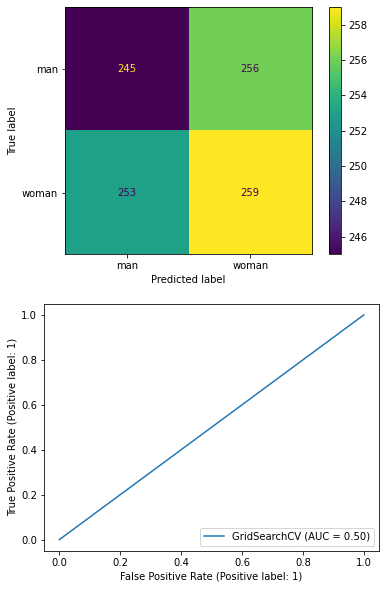

In [1013]:
dc_pipe=Pipeline([
    ('cv',CountVectorizer()),
    ('dc',DummyClassifier(random_state=42,strategy='uniform')) #strategy is 'uniform', because it will generate predictions uniformly and each class will have equal probability. Same as our target feature.
])
#I've putted it into a Grid so the calculate method could work
dummy_grid=GridSearchCV(estimator=dc_pipe,param_grid={})
dummy_grid.fit(X_train,y_train)
y_pred=dummy_grid.predict(X_test)
calculate(dummy_grid);


Method that returns united Dataframe with X_test, y_real and y_predicted data to analyse mispredictions.

In [650]:
def get_df_pred(estimator):
    y_predict=estimator.predict(X_test) #getting predicted values
    X_test_pred=pd.DataFrame(X_test) #basic dataset
    X_test_pred["real"]=y_test #adding y_real
    X_test_pred.reset_index(inplace=True) #dropping index
    X_test_pred['predicted']=y_predict #adding predicted values
    return X_test_pred

textstat library can be useful, readability score david chale

----

# Modeling data

#### Logistic Regression + CountVectorizer through GridSearch

In [1051]:
log_pipe=Pipeline([
('cvec',CountVectorizer()),
('log_reg',LogisticRegression(random_state=42,max_iter=5000))
])

pipe_params={
    'cvec__max_features':[1000,2000,3000,5000],
    # # 'cvec__min_df':[0.0001,0.0002],
    # 'cvec__max_df':[0.95,0.99,1],
    'cvec__ngram_range':[(1,2),(1,3),(2,2),(3,3)],
    'log_reg__penalty':['l1','l2'],
    'log_reg__C':[0.001]
}


In [1052]:
log_grid=GridSearchCV(
    log_pipe,
    param_grid=pipe_params,
    n_jobs=-1,
    cv=3,
    verbose=1
)

log_grid.fit(X_train,y_train);

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logist

X_train Score : 0.650197628458498
X_test Score  : 0.6169792694965449
F1 Test Score: 0.555045871559633
Sensitivity: 0.4727
Specificity: 0.7645
Precision  : 0.6722
Baseline accuracy : 0.5054294175715696
Best estimator : Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('log_reg',
                 LogisticRegression(C=0.001, max_iter=5000, random_state=42))])
Best score :  0.6287878787878788
Best parameters : {'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'log_reg__C': 0.001, 'log_reg__penalty': 'l2'}


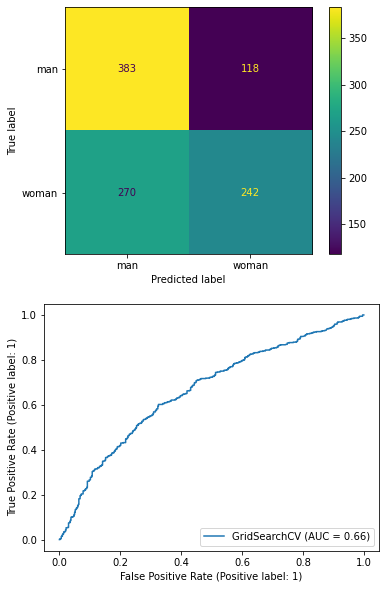

In [1053]:
calculate(log_grid);

#### Naive Bayes + CountVectorizer through GridSearch

In [782]:
nb_pipe=Pipeline([
('cvec',CountVectorizer()),
('nb',MultinomialNB())
])
nb_pipe_params={
'cvec__min_df':[2,3],
'cvec__max_df':[0.95,0.98,1],
'cvec__ngram_range':[(1,2),(2,2),(2,3),(3,3)],
'cvec__stop_words':['english', None],
'cvec__max_features':[1000,2000,3000],
'cvec__ngram_range':[(1,1),(1,2)]

}

In [783]:
nb_grid=GridSearchCV(nb_pipe,
param_grid=nb_pipe_params,
cv=3,
verbose=1,
n_jobs=-1
)
nb_grid.fit(X_train,y_train);


Fitting 3 folds for each of 72 candidates, totalling 216 fits


/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
72 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 355, in _fit
   

X_train Score : 0.7753623188405797
X_test Score  : 0.6189536031589339
F1 Test Score: 0.6385767790262172
Sensitivity: 0.666
Specificity: 0.5709
Precision  : 0.6133
Baseline accuracy : 0.5054294175715696
Best estimator : Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.95, max_features=3000, min_df=2,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB())])
Best score :  0.5965085638998683
Best parameters : {'cvec__max_df': 0.95, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None}


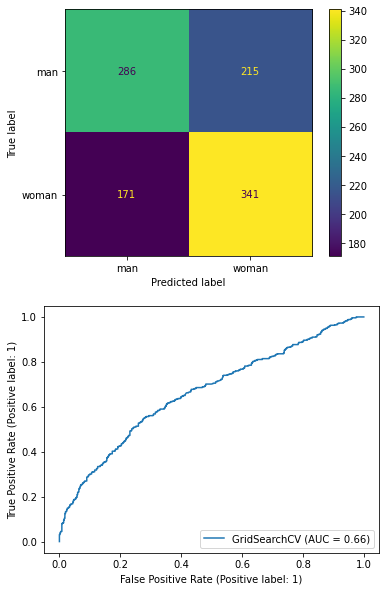

In [1015]:
calculate(nb_grid);

#### Decision Tree with TFIDF through GridSearchCV

In [797]:
d_tree_pipe=Pipeline([
('tf',TfidfVectorizer()),
('dt',DecisionTreeClassifier())
])

d_tree_pipe_params={
'tf__stop_words':[None],
'tf__ngram_range':[(1,1),(1,2),(1,3),(2,3)],
# 'tf__max_df':[0.9,0.95,0.98],
# 'tf__min_df':[2,3,4,5],
'dt__max_depth':[9,10,11],
'dt__min_samples_split':[8,10,13],
'dt__min_samples_leaf':[8,10,13]


}

In [798]:
d_tree_grid=GridSearchCV(d_tree_pipe,param_grid=d_tree_pipe_params,cv=3,n_jobs=-1,verbose=1)
d_tree_grid.fit(X_train,y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('dt', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'dt__max_depth': [9, 10, 11],
                         'dt__min_samples_leaf': [8, 10, 13],
                         'dt__min_samples_split': [8, 10, 13],
                         'tf__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 3)],
                         'tf__stop_words': [None]},
             verbose=1)

X_train Score : 0.66600790513834
X_test Score  : 0.5972359328726555
F1 Test Score: 0.46174142480211083
Sensitivity: 0.3418
Specificity: 0.8583
Precision  : 0.7114
Baseline accuracy : 0.5054294175715696
Best estimator : Pipeline(steps=[('tf', TfidfVectorizer()),
                ('dt',
                 DecisionTreeClassifier(max_depth=9, min_samples_leaf=13,
                                        min_samples_split=8))])
Best score :  0.6136363636363636
Best parameters : {'dt__max_depth': 9, 'dt__min_samples_leaf': 13, 'dt__min_samples_split': 8, 'tf__ngram_range': (1, 1), 'tf__stop_words': None}


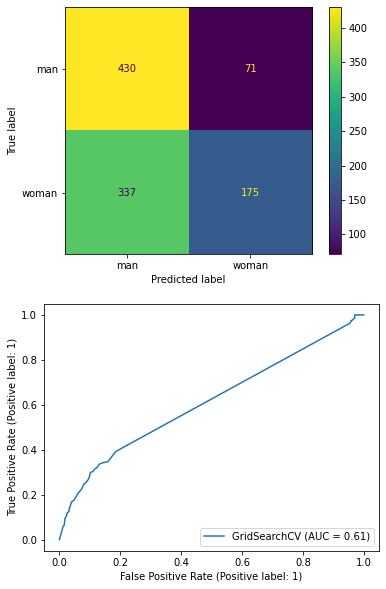

In [1016]:
calculate(d_tree_grid);

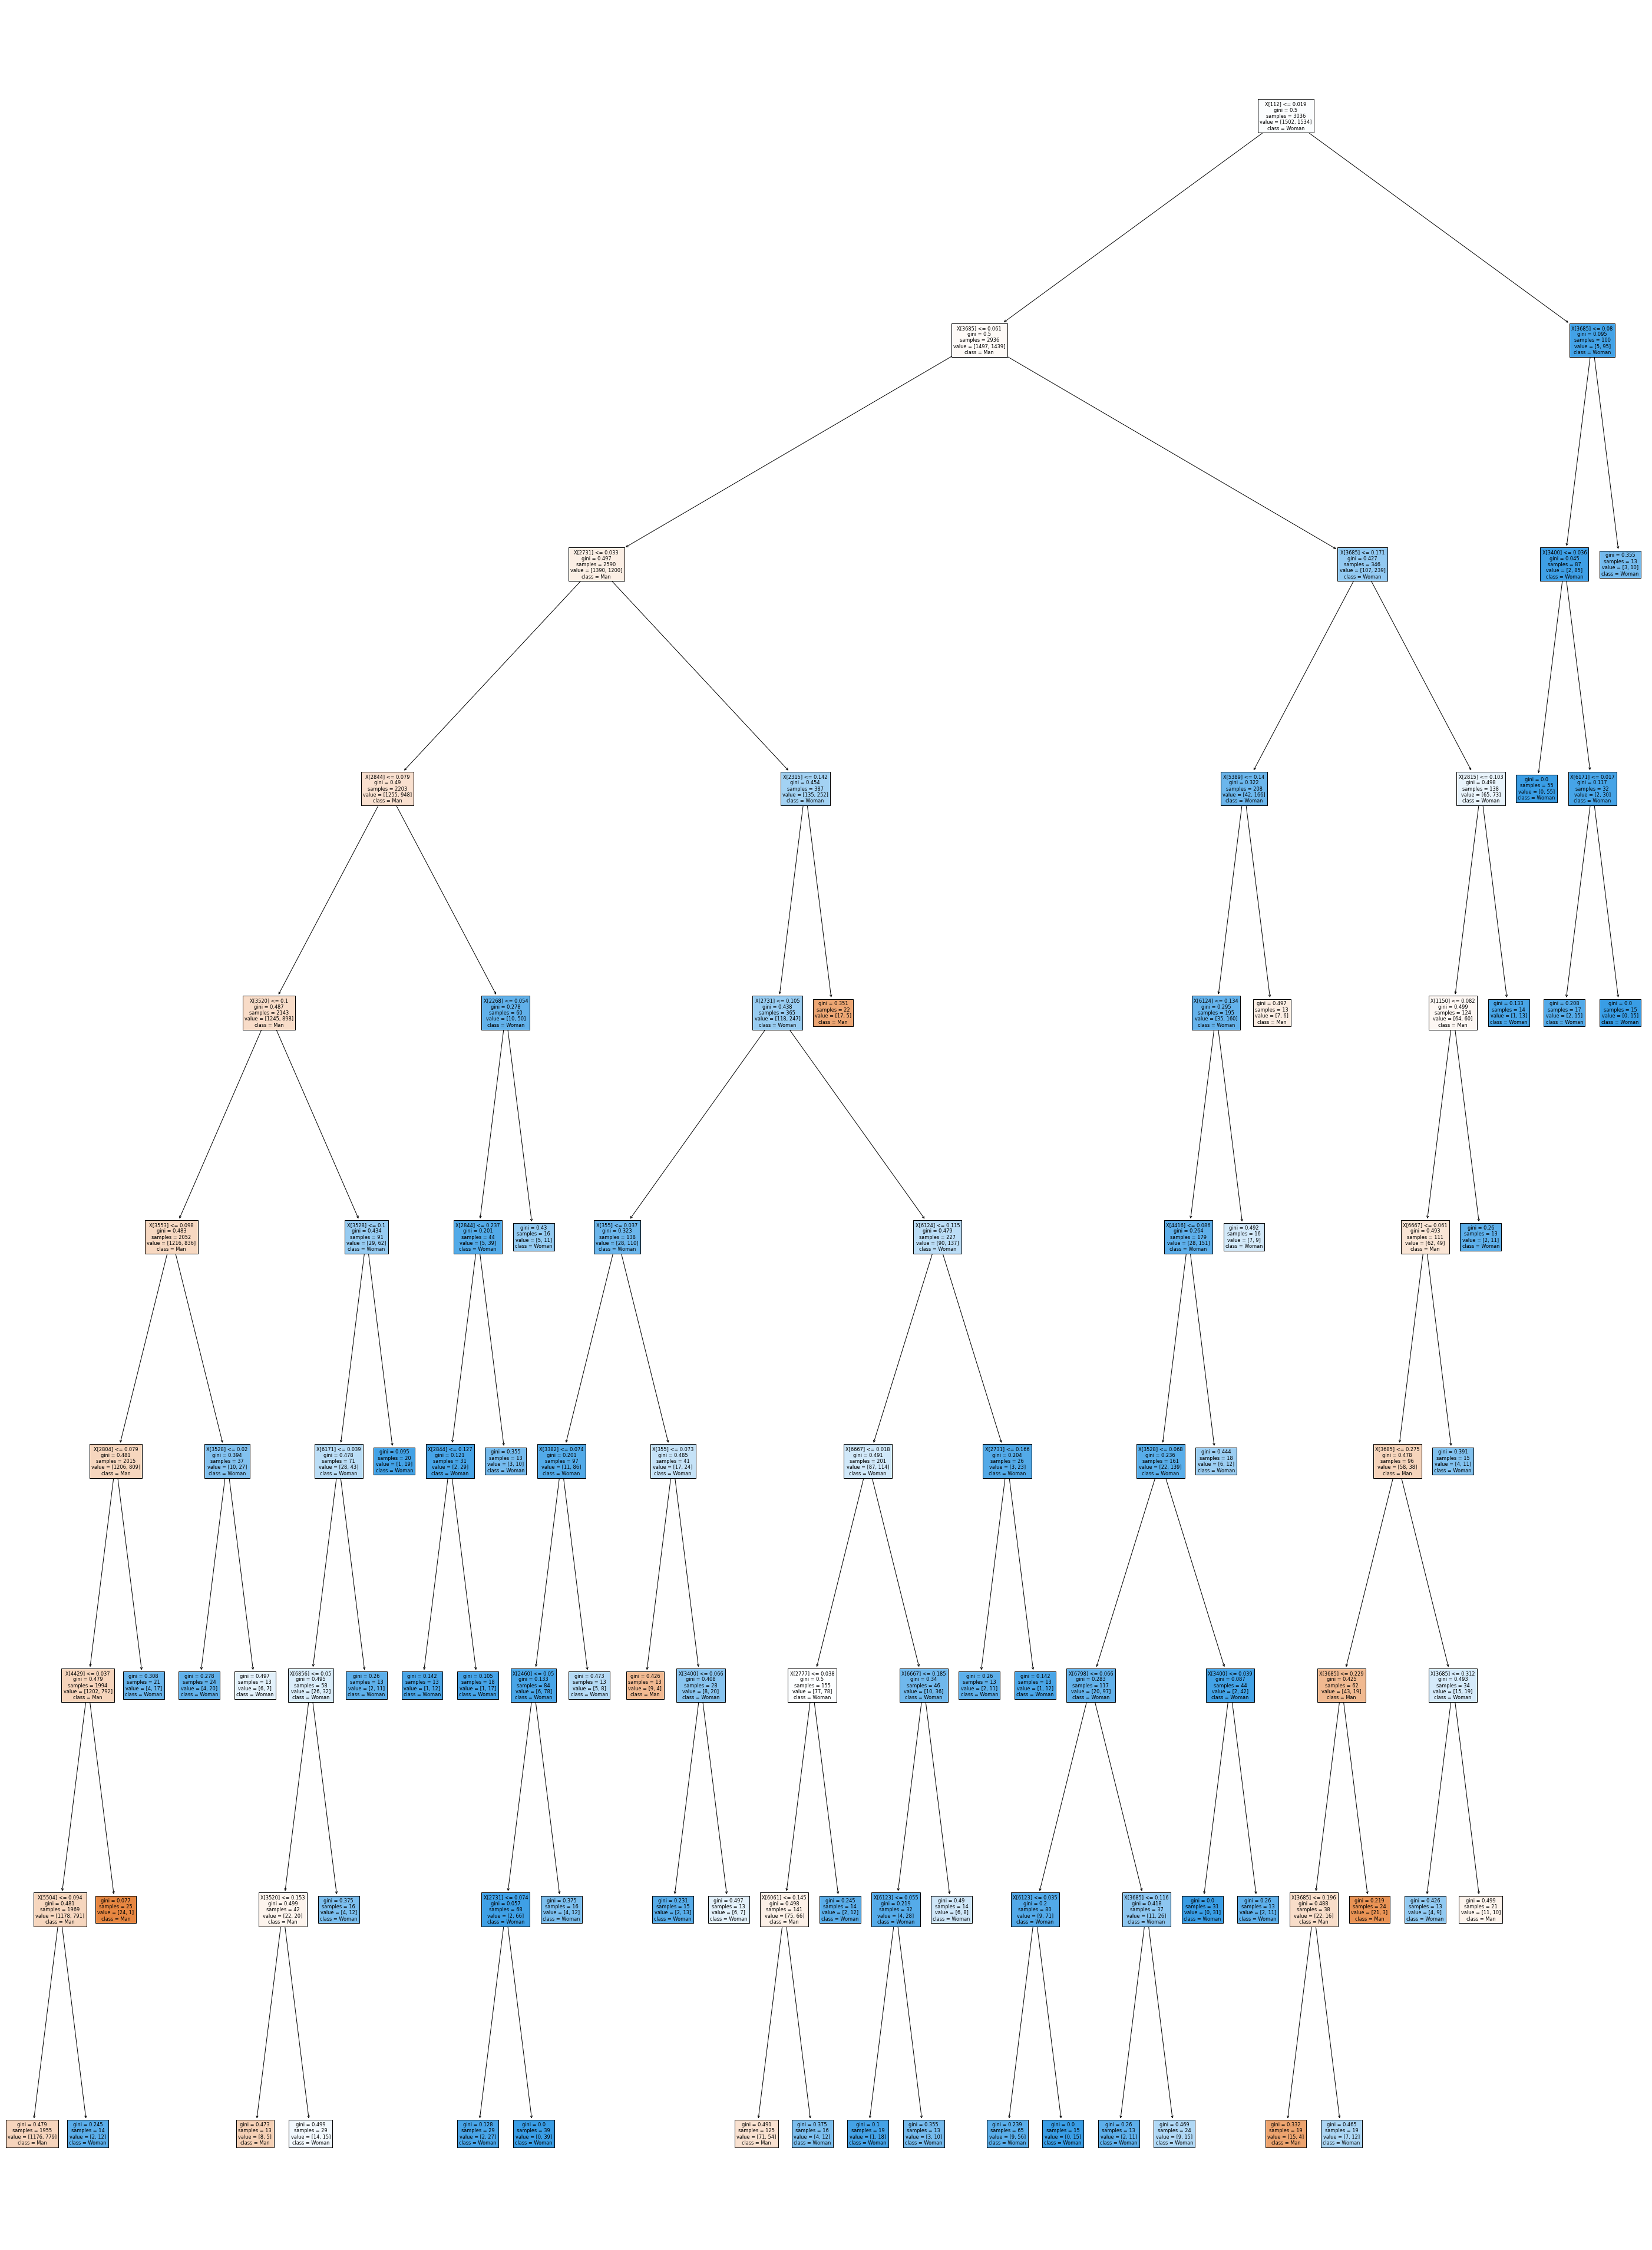

In [800]:
plt.figure(figsize = (50, 70))

# Plot our tree.
plot_tree(d_tree_grid.best_estimator_["dt"],
        #   feature_names = "X_train.name",
          class_names = ['Man', 'Woman'],
          filled = True);

#### TFDIDF + Bagging through GridSeardchCV

In [801]:
bag_pipeline=Pipeline([
    ('tf',TfidfVectorizer()),
    ('bag',BaggingClassifier(random_state=42,))
])
bag_pipeline_params={
'tf__stop_words':[None],
'tf__ngram_range':[(1,3),(1,4),(2,2)],
# 'tf__max_df':[0.9,0.95,0.98],
# 'tf__min_df':[2,3,4,5],
'bag__n_estimators':[5,20,60,100]
}

In [802]:
bag_grid=GridSearchCV(bag_pipeline,param_grid=bag_pipeline_params,cv=3, verbose=1,n_jobs=-1)
bag_grid.fit(X_train,y_train);

Fitting 3 folds for each of 12 candidates, totalling 36 fits


X_train Score : 0.9496047430830039
X_test Score  : 0.5844027640671273
F1 Test Score: 0.5768844221105528
Sensitivity: 0.5605
Specificity: 0.6088
Precision  : 0.5942
Baseline accuracy : 0.5054294175715696
Best estimator : Pipeline(steps=[('tf', TfidfVectorizer(ngram_range=(1, 3))),
                ('bag', BaggingClassifier(n_estimators=5, random_state=42))])
Best score :  0.6017786561264823
Best parameters : {'bag__n_estimators': 5, 'tf__ngram_range': (1, 3), 'tf__stop_words': None}


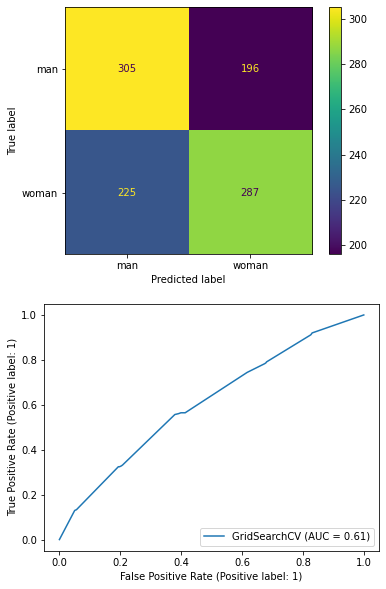

In [1017]:
calculate(bag_grid);

#### RandomForest + CountVectorizer through GridSearchCV

In [1063]:
rand_pipeline=Pipeline([
    ('cv',CountVectorizer()),
    ('rand',RandomForestClassifier(random_state=42))
])
rand_pipeline_params={
# 'cv__stop_words':[None],
'cv__ngram_range':[(1,2),(1,3)],
'cv__max_features':[500,2000],
'cv__max_df':[0.05,0.1,0.2,0.3],
# 'cv__min_df':[2,5,10],
'rand__n_estimators':[100],
'rand__max_depth':[6,8],
'rand__min_samples_split':[2,6],
'rand__min_samples_leaf':[1,2,3]
}

In [1064]:
rand_grid=GridSearchCV(rand_pipeline,param_grid=rand_pipeline_params,cv=3,verbose=1,n_jobs=-1)
rand_grid.fit(X_train,y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rand',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'cv__max_df': [0.05, 0.1, 0.2, 0.3],
                         'cv__max_features': [500, 2000],
                         'cv__ngram_range': [(1, 2), (1, 3)],
                         'rand__max_depth': [6, 8],
                         'rand__min_samples_leaf': [1, 2, 3],
                         'rand__min_samples_split': [2, 6],
                         'rand__n_estimators': [100]},
             verbose=1)

X_train Score : 0.6831357048748353
X_test Score  : 0.6209279368213229
F1 Test Score: 0.5923566878980892
Sensitivity: 0.5449
Specificity: 0.6986
Precision  : 0.6488
Baseline accuracy : 0.5054294175715696
Best estimator : Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.2, max_features=2000,
                                 ngram_range=(1, 2))),
                ('rand',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=2,
                                        random_state=42))])
Best score :  0.6462450592885375
Best parameters : {'cv__max_df': 0.2, 'cv__max_features': 2000, 'cv__ngram_range': (1, 2), 'rand__max_depth': 6, 'rand__min_samples_leaf': 2, 'rand__min_samples_split': 2, 'rand__n_estimators': 100}


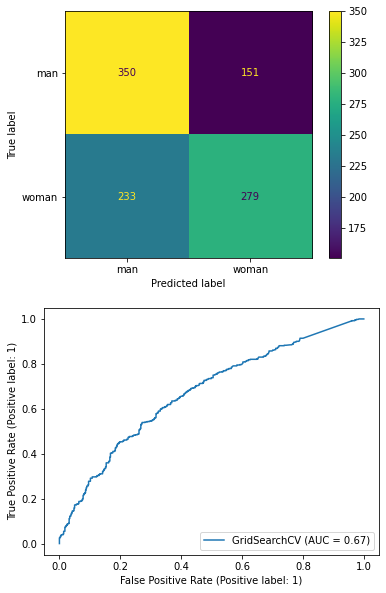

In [1065]:
calculate(rand_grid);

#### AdaBoost+TFIDF through GridSearchCV

In [966]:

ada_pipe=Pipeline([
('tf',TfidfVectorizer()),
('ada',AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))

])

ada_pipe_params={
'tf__stop_words':[None],
'tf__ngram_range':[(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(3,3)],
# 'tf__max_df':[0.9,0.95],
# 'tf__min_df':[2,3,4,5],
# 'ada__n_estimators':[50,100],
'ada__base_estimator__max_depth':[1,2],
'ada__learning_rate':[0.9,1.01]
}


In [811]:
ada_grid=GridSearchCV(ada_pipe,param_grid=ada_pipe_params,cv=3,verbose=1,n_jobs=-1)
ada_grid.fit(X_train,y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]),
             n_jobs=-1,
             param_grid={'ada__base_estimator__max_depth': [1, 2],
                         'ada__learning_rate': [0.9, 1.01],
                         'tf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4),
                                             (2, 2), (2, 3), (3, 3)],
                         'tf__stop_words': [None]},
             verbose=1)

X_train Score : 0.6976284584980237
X_test Score  : 0.6377097729516288
F1 Test Score: 0.6058002148227712
Sensitivity: 0.5508
Specificity: 0.7265
Precision  : 0.673
Baseline accuracy : 0.5054294175715696
Best estimator : Pipeline(steps=[('tf', TfidfVectorizer()),
                ('ada',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=1.01))])
Best score :  0.6185770750988142
Best parameters : {'ada__base_estimator__max_depth': 1, 'ada__learning_rate': 1.01, 'tf__ngram_range': (1, 1), 'tf__stop_words': None}


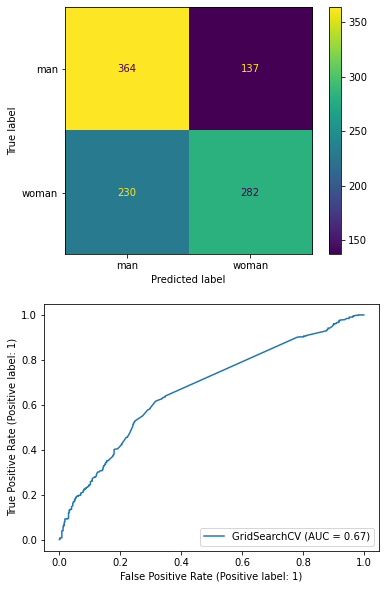

In [1019]:
calculate(ada_grid);

#### Stacking with CountVectorizer

In [813]:

level1_estimators=[
    ('log_pipe',Pipeline([
        ('cv',CountVectorizer()),
        ('log', LogisticRegression(random_state=42,max_iter=10000))
    ])),
    ('knn_pipe',Pipeline([
        ('cv',CountVectorizer()),
        ('knn',KNeighborsClassifier())
    ])),
    ('bag_pipe',Pipeline([
        ('cv',CountVectorizer()),
        ('bag',BaggingClassifier())
    ])),
    ('ada_pipe',Pipeline([
        ('cv',CountVectorizer()),
        ('ada',AdaBoostClassifier())
    ]))
]

stacked_model=StackingClassifier(estimators=level1_estimators,final_estimator=LogisticRegression(max_iter=1000),)

In [1010]:
#this is basic hyperparameters set, adding full set would take too much time to calculate
stacked_params={
    'log_pipe__cv__ngram_range':[(1,2),(1,3)],
    'knn_pipe__cv__ngram_range':[(1,2),(1,3)],
    'bag_pipe__cv__ngram_range':[(1,2),(1,3)],
    'ada_pipe__cv__ngram_range':[(1,2),(1,3)],
}
stacked_grid=GridSearchCV(stacked_model,param_grid=stacked_params,cv=3,verbose=1,n_jobs=-1)
stacked_grid.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=StackingClassifier(estimators=[('log_pipe',
                                                       Pipeline(steps=[('cv',
                                                                        CountVectorizer()),
                                                                       ('log',
                                                                        LogisticRegression(max_iter=10000,
                                                                                           random_state=42))])),
                                                      ('knn_pipe',
                                                       Pipeline(steps=[('cv',
                                                                        CountVectorizer()),
                                                                       ('knn',
                                                                        KNeighborsClassifier())])),
                             

X_train Score : 0.9917654808959157
X_test Score  : 0.648568608094768
F1 Test Score: 0.6461232604373758
Sensitivity: 0.6348
Specificity: 0.6627
Precision  : 0.6579
Baseline accuracy : 0.5054294175715696
Best estimator : StackingClassifier(estimators=[('log_pipe',
                                Pipeline(steps=[('cv',
                                                 CountVectorizer(ngram_range=(1,
                                                                              2))),
                                                ('log',
                                                 LogisticRegression(max_iter=10000,
                                                                    random_state=42))])),
                               ('knn_pipe',
                                Pipeline(steps=[('cv', CountVectorizer()),
                                                ('knn',
                                                 KNeighborsClassifier())])),
                               ('ba

{<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7fe359c0af90>, None}

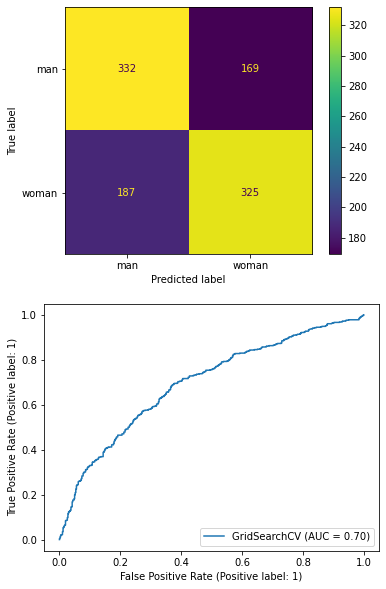

In [1020]:
calculate(stacked_grid)

## Modeling summary

To analyse models results we should define metrics that should be used. According to our problem statement, stakeholders want to predict both classes equally, that mean our target score is f1, which is harmonic mean of precision and recall. And the second metric would be accuracy score.

Baseline accuracy f1 score is <dev>0.5043816942551119<dev> and Baseline accuracy is <dev>0.5054294175715696<dev> let's compare with models results.
ROC-AUC is within a range 0.6-0.7 for all models. That mean that our classes are highly overlapped and models are unable to devide them.
All models show similar results that are very close to the baseline accuracy, 


----

#EDA on Results

### Logistic Regression

In [817]:
feature_coef=pd.DataFrame(log_grid.best_estimator_.named_steps.cvec.get_feature_names())
feature_coef["coef"]=log_grid.best_estimator_.named_steps.log_reg.coef_[0]
my_additional_stop_words=list(feature_coef.sort_values(by="coef", ascending=False).tail(30)[0])
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)
my_additional_stop_words


['pregnant',
 'recommendation',
 'acknowledge',
 'reliable',
 'encounter',
 'lose weight',
 'quiet',
 'bunch',
 'little thing',
 'land',
 'upset',
 'guy guy',
 'face',
 'thing woman',
 'laundry',
 'photo',
 'interaction',
 'sad',
 'flag',
 'makeup',
 'bras',
 'fart',
 'product',
 'penis size',
 'class',
 'rude',
 'subreddit',
 'period',
 'lady',
 'cry']

In [819]:
predicted_log_reg=get_df_pred(log_grid)
predicted_log_reg_mismatch=predicted_log_reg[predicted_log_reg["real"]!=predicted_log_reg["predicted"]]
predicted_log_reg_mismatch.head(10)

,index,comment,real,predicted
1,1249,I woman post love picnic bookstore date man post want,1,0
6,3212,I collect play doll know odd desire play doll,0,1
8,618,drink month ago little drunk start stupid shit life mainly ignore work week begin join work conversation team day begin message slack leave town work week start monday morning office chat forth bit end exchange number share tea member team flirt non stop blatantly state appreciate intimidate I want plan hang week leave utterly confused month feel like elaborate prank happen,1,0
10,1606,I lot post site nut immediately feel ashamed kind thing watch feel regret shame wrong,1,0
13,2959,look find reasonably price shampoo conditioner thought hear like use,0,1
15,2745,favorite office place workplace lifehack help,0,1
17,1975,I know plan propose married know ring size partner fiancé wife,1,0
23,1752,month ago decide finally jungle pubic hair preferred method scissor cut lot month line hair near area look like mess grow way expect use scissor instead permanently trim forever,1,0
24,1648,work progress explanation boss manager letter sure reply amp dear greeting cold monday truly mystified wrong mistake perform duty clean driver desire learn utter incompetence year drive experience preference use google map instead waze wrong turn waze late time long eat breakfast day matter generous help strive equip driver job thank million advance way send driver collect vacuu...,1,0
27,3575,I apply job assessment job local university score applicant include professor engineer scientist think pretty good consider struggle math excite tell parent basically good like qualify job event planning position struggle believe finally able comfort zone apply job little challenging I know guess believe feel good,0,1


In [820]:
predicted_log_reg_match=predicted_log_reg[predicted_log_reg["real"]==predicted_log_reg["predicted"]]
predicted_log_reg_match.head(10)

,index,comment,real,predicted
0,3102,I random pink clot discharge come scared implantation bleed instance pregnancy second stop bad idea come minute later doubt pregnancy precum scared sure period come,0,0
2,3752,kind doubt hard time know anxiety anxiety bad,0,0
3,866,recently talk ex lightly mention probably clue girlfriend actually look like,1,1
4,2522,crazy sexual fantasy,0,0
5,3827,prefer bland food seasoned food,0,0
7,3573,answer,0,0
9,1326,kind long bear perspective today start good boss bad mood start unload truck cheer man friday polite way start stupid know feel happy friday okay continue work later start fucking end different different like different different technically point aggravate stick rest day feel kind hurt mean tell different mean way fast forward end day lock store shut light ask lock door yes scream I long hey l...,1,1
11,2975,awkward situation use live dude usually wear bras leave house find constrict uncomfortable wear bras usually soon home thing gay dude long term boyfriend chance perve I worried feel like rude uncomfortable dress properly proper polite worry feel weird bra relatively big boob definitely noticeable wear bra wear sport bras moment tight uncomfy support guy think wear bra wear,0,0
12,1974,guy date month distant texte hit want hang mantain friendship right agree thinking friend text day silly stuff like ask plan day series recommendation personally communicate friend day know appreciate want friendship receive text single day small silly thing force,1,1
14,821,I think bar like hooter,1,1


In [910]:
log_reg_features=pd.DataFrame(log_grid.best_estimator_.named_steps.log_reg.coef_[0])
log_reg_features['feature']=log_grid.best_estimator_.named_steps.cvec.get_feature_names_out()
log_reg_features.columns=['coef',"feature"]
log_reg_features.sort_values(by='coef',ascending=False)
log_reg_features['exp']=np.exp(log_reg_features['coef'])
log_reg_features.sort_values(by='exp',ascending=False)

,coef,feature,exp
62,2.172532,advice,8.780488
1756,1.570825,guy think,4.810617
1872,1.559255,help,4.755278
546,1.386526,cheap,4.000927
2974,1.273100,obvious,3.571909
...,...,...,...
3599,-1.122622,rude,0.325425
4038,-1.253379,subreddit,0.285538
3139,-1.277632,period,0.278697
2255,-1.294778,lady,0.273959


In [917]:
log_most_imp_feat=log_reg_features.sort_values(by='exp',ascending=False).iloc[:10]
log_most_imp_feat=log_most_imp_feat.append(log_reg_features.sort_values(by='exp',ascending=False).iloc[-10:])

In [919]:
log_most_imp_feat

,coef,feature,exp
62,2.172532,advice,8.780488
1756,1.570825,guy think,4.810617
1872,1.559255,help,4.755278
546,1.386526,cheap,4.000927
2974,1.273100,obvious,3.571909
2747,1.271927,men,3.567720
840,1.204971,dad,3.336664
1007,1.140336,divorce,3.127818
3981,1.131554,stick,3.100471
298,1.109500,bar,3.032842


<Figure size 432x288 with 0 Axes>

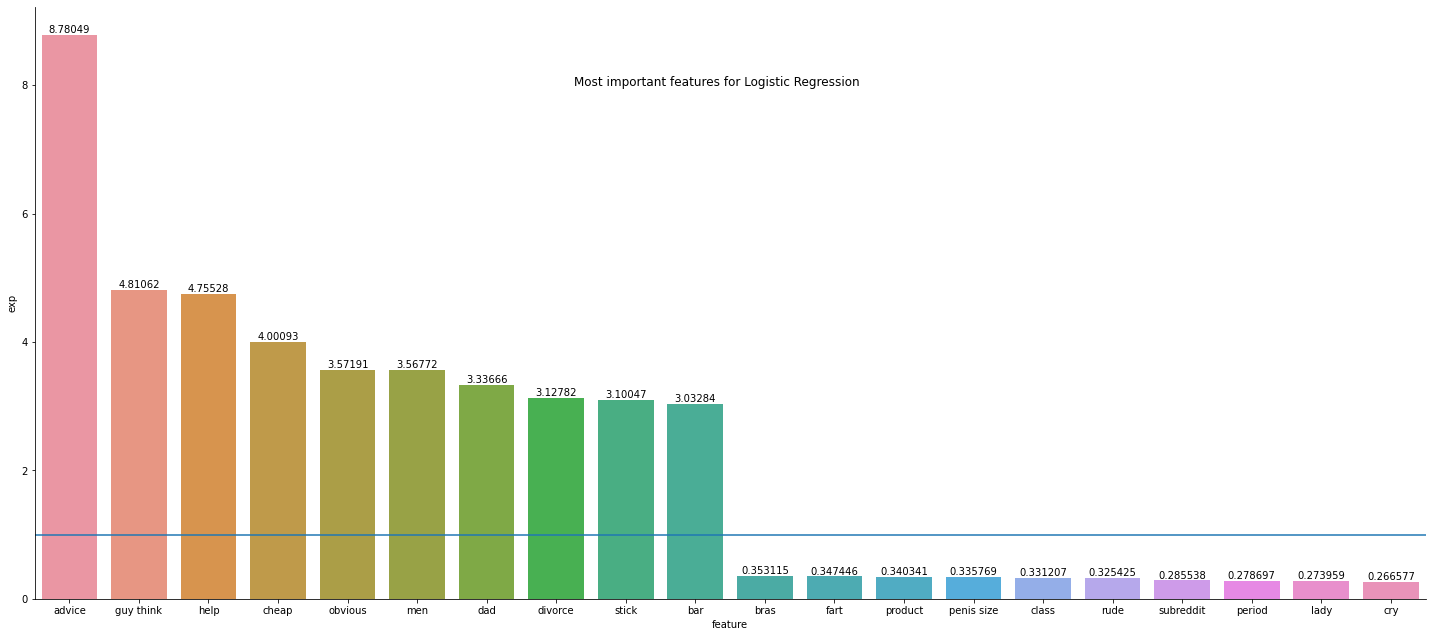

In [949]:
# plot
plt.tight_layout()
g = sns.catplot(kind='bar', data=log_most_imp_feat, x='feature', y='exp', height=8, aspect=2.5)
g.fig.subplots_adjust(top=1.1)
# g.a (1)
g.fig.suptitle('Most important features for Logistic Regression')

# iterate through the axes
for ax in g.axes.flat:

    # annotate
    ax.bar_label(ax.containers[0], label_type='edge')
    ax.axhline(1)
    # pad the spacing between the number and the edge of the figure; should be in the loop, otherwise only the last subplot would be adjusted
    ax.margins(y=0.05)
plt.savefig('../resources/Top_10_log_reg.png')


### Naive Bayes

In [821]:
predicted_nb=get_df_pred(nb_grid)
predicted_nb_mismatch=predicted_nb[predicted_nb["real"]!=predicted_nb["predicted"]]
predicted_nb_mismatch.head(10)


,index,comment,real,predicted
4,2522,crazy sexual fantasy,0,1
6,3212,I collect play doll know odd desire play doll,0,1
8,618,drink month ago little drunk start stupid shit life mainly ignore work week begin join work conversation team day begin message slack leave town work week start monday morning office chat forth bit end exchange number share tea member team flirt non stop blatantly state appreciate intimidate I want plan hang week leave utterly confused month feel like elaborate prank happen,1,0
10,1606,I lot post site nut immediately feel ashamed kind thing watch feel regret shame wrong,1,0
12,1974,guy date month distant texte hit want hang mantain friendship right agree thinking friend text day silly stuff like ask plan day series recommendation personally communicate friend day know appreciate want friendship receive text single day small silly thing force,1,0
13,2959,look find reasonably price shampoo conditioner thought hear like use,0,1
15,2745,favorite office place workplace lifehack help,0,1
17,1975,I know plan propose married know ring size partner fiancé wife,1,0
23,1752,month ago decide finally jungle pubic hair preferred method scissor cut lot month line hair near area look like mess grow way expect use scissor instead permanently trim forever,1,0
24,1648,work progress explanation boss manager letter sure reply amp dear greeting cold monday truly mystified wrong mistake perform duty clean driver desire learn utter incompetence year drive experience preference use google map instead waze wrong turn waze late time long eat breakfast day matter generous help strive equip driver job thank million advance way send driver collect vacuu...,1,0


In [822]:
predicted_nb_match=predicted_nb[predicted_nb["real"]==predicted_nb["predicted"]]
predicted_nb_match.head(10)

,index,comment,real,predicted
0,3102,I random pink clot discharge come scared implantation bleed instance pregnancy second stop bad idea come minute later doubt pregnancy precum scared sure period come,0,0
1,1249,I woman post love picnic bookstore date man post want,1,1
2,3752,kind doubt hard time know anxiety anxiety bad,0,0
3,866,recently talk ex lightly mention probably clue girlfriend actually look like,1,1
5,3827,prefer bland food seasoned food,0,0
7,3573,answer,0,0
9,1326,kind long bear perspective today start good boss bad mood start unload truck cheer man friday polite way start stupid know feel happy friday okay continue work later start fucking end different different like different different technically point aggravate stick rest day feel kind hurt mean tell different mean way fast forward end day lock store shut light ask lock door yes scream I long hey l...,1,1
11,2975,awkward situation use live dude usually wear bras leave house find constrict uncomfortable wear bras usually soon home thing gay dude long term boyfriend chance perve I worried feel like rude uncomfortable dress properly proper polite worry feel weird bra relatively big boob definitely noticeable wear bra wear sport bras moment tight uncomfy support guy think wear bra wear,0,0
14,821,I think bar like hooter,1,1
16,3352,kind embarrassing young randomly decide shave small section belly button present self annoyance blonde fine hair noticeable hair grow dark little thick long pluck recently hair ingrown hair difficult little painful way deal ideally hair normal possible,0,0


----
### Decision Tree

In [823]:
predicted_dt=get_df_pred(d_tree_grid)
predicted_dt_mismatch=predicted_dt[predicted_dt["real"]!=predicted_dt["predicted"]]
predicted_dt_mismatch.head(10)

,index,comment,real,predicted
3,866,recently talk ex lightly mention probably clue girlfriend actually look like,1,0
8,618,drink month ago little drunk start stupid shit life mainly ignore work week begin join work conversation team day begin message slack leave town work week start monday morning office chat forth bit end exchange number share tea member team flirt non stop blatantly state appreciate intimidate I want plan hang week leave utterly confused month feel like elaborate prank happen,1,0
10,1606,I lot post site nut immediately feel ashamed kind thing watch feel regret shame wrong,1,0
11,2975,awkward situation use live dude usually wear bras leave house find constrict uncomfortable wear bras usually soon home thing gay dude long term boyfriend chance perve I worried feel like rude uncomfortable dress properly proper polite worry feel weird bra relatively big boob definitely noticeable wear bra wear sport bras moment tight uncomfy support guy think wear bra wear,0,1
14,821,I think bar like hooter,1,0
15,2745,favorite office place workplace lifehack help,0,1
17,1975,I know plan propose married know ring size partner fiancé wife,1,0
20,1939,I year old male consider fairly attractive little issue match date app eye bar month long term relationship know clueless feel weird ask girl right hook know plenty direct treat tinder date potential partner progress slow turn moreso seek potential partner point think thing thing feel awkward think place fucking leave,1,0
21,1033,apparently common thought accord tiktok like ask boyfriend spend day teleportation portal,1,0
23,1752,month ago decide finally jungle pubic hair preferred method scissor cut lot month line hair near area look like mess grow way expect use scissor instead permanently trim forever,1,0


In [824]:
predicted_dt_match=predicted_dt[predicted_dt["real"]==predicted_dt["predicted"]]
predicted_dt_match.head(10)

,index,comment,real,predicted
0,3102,I random pink clot discharge come scared implantation bleed instance pregnancy second stop bad idea come minute later doubt pregnancy precum scared sure period come,0,0
1,1249,I woman post love picnic bookstore date man post want,1,1
2,3752,kind doubt hard time know anxiety anxiety bad,0,0
4,2522,crazy sexual fantasy,0,0
5,3827,prefer bland food seasoned food,0,0
6,3212,I collect play doll know odd desire play doll,0,0
7,3573,answer,0,0
9,1326,kind long bear perspective today start good boss bad mood start unload truck cheer man friday polite way start stupid know feel happy friday okay continue work later start fucking end different different like different different technically point aggravate stick rest day feel kind hurt mean tell different mean way fast forward end day lock store shut light ask lock door yes scream I long hey l...,1,1
12,1974,guy date month distant texte hit want hang mantain friendship right agree thinking friend text day silly stuff like ask plan day series recommendation personally communicate friend day know appreciate want friendship receive text single day small silly thing force,1,1
13,2959,look find reasonably price shampoo conditioner thought hear like use,0,0


In [900]:
d_tree_features=pd.DataFrame(d_tree_grid.best_estimator_.named_steps.dt.feature_importances_)
d_tree_features['feature']=d_tree_grid.best_estimator_.named_steps.tf.get_feature_names_out()
d_tree_features.columns=['coef',"feature"]
d_tree_features.sort_values(by="coef",ascending=False)

,coef,feature
3685,0.204369,man
112,0.152310,advice
2731,0.144382,guy
2844,0.076516,help
3520,0.049862,life
...,...,...
2292,0.000000,fictional
2291,0.000000,fiction
2290,0.000000,fiber
2289,0.000000,fiancé


In [940]:
d_tree_imp_feat=d_tree_features.sort_values(by='coef',ascending=False).iloc[:10]
# d_tree_imp_feat=log_most_imp_feat.append(log_reg_features.sort_values(by='exp',ascending=False).iloc[-10:])
d_tree_imp_feat

,coef,feature
3685,0.204369,man
112,0.152310,advice
2731,0.144382,guy
2844,0.076516,help
3520,0.049862,life
6667,0.038308,want
2315,0.031213,find
355,0.030405,ask
3553,0.029152,live
2804,0.026312,head


<Figure size 432x288 with 0 Axes>

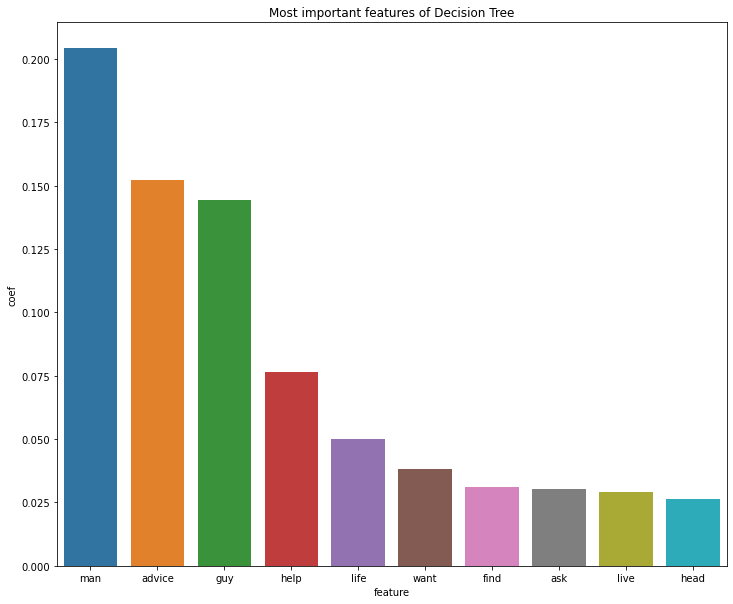

In [948]:
plt.tight_layout()
plt.figure(figsize=(12,10))
sns.barplot(x=d_tree_imp_feat['feature'],y=d_tree_imp_feat['coef']).set(title="Most important features of Decision Tree")
plt.savefig('../resources/features_decision_tree.png')



This coefficient tells us how was important feature according to the model and shows total reduction (normalized) of the Gini coef brought by that feature.

----
### Bagging

In [825]:

predicted_bag=get_df_pred(bag_grid)
predicted_bag_mismatch=predicted_bag[predicted_bag["real"]!=predicted_bag["predicted"]]
predicted_bag_mismatch.head(10)

,index,comment,real,predicted
2,3752,kind doubt hard time know anxiety anxiety bad,0,1
4,2522,crazy sexual fantasy,0,1
7,3573,answer,0,1
10,1606,I lot post site nut immediately feel ashamed kind thing watch feel regret shame wrong,1,0
11,2975,awkward situation use live dude usually wear bras leave house find constrict uncomfortable wear bras usually soon home thing gay dude long term boyfriend chance perve I worried feel like rude uncomfortable dress properly proper polite worry feel weird bra relatively big boob definitely noticeable wear bra wear sport bras moment tight uncomfy support guy think wear bra wear,0,1
15,2745,favorite office place workplace lifehack help,0,1
16,3352,kind embarrassing young randomly decide shave small section belly button present self annoyance blonde fine hair noticeable hair grow dark little thick long pluck recently hair ingrown hair difficult little painful way deal ideally hair normal possible,0,1
17,1975,I know plan propose married know ring size partner fiancé wife,1,0
20,1939,I year old male consider fairly attractive little issue match date app eye bar month long term relationship know clueless feel weird ask girl right hook know plenty direct treat tinder date potential partner progress slow turn moreso seek potential partner point think thing thing feel awkward think place fucking leave,1,0
23,1752,month ago decide finally jungle pubic hair preferred method scissor cut lot month line hair near area look like mess grow way expect use scissor instead permanently trim forever,1,0


In [826]:
predicted_bag_match=predicted_bag[predicted_bag["real"]==predicted_bag["predicted"]]
predicted_bag_match.head(10)

,index,comment,real,predicted
0,3102,I random pink clot discharge come scared implantation bleed instance pregnancy second stop bad idea come minute later doubt pregnancy precum scared sure period come,0,0
1,1249,I woman post love picnic bookstore date man post want,1,1
3,866,recently talk ex lightly mention probably clue girlfriend actually look like,1,1
5,3827,prefer bland food seasoned food,0,0
6,3212,I collect play doll know odd desire play doll,0,0
8,618,drink month ago little drunk start stupid shit life mainly ignore work week begin join work conversation team day begin message slack leave town work week start monday morning office chat forth bit end exchange number share tea member team flirt non stop blatantly state appreciate intimidate I want plan hang week leave utterly confused month feel like elaborate prank happen,1,1
9,1326,kind long bear perspective today start good boss bad mood start unload truck cheer man friday polite way start stupid know feel happy friday okay continue work later start fucking end different different like different different technically point aggravate stick rest day feel kind hurt mean tell different mean way fast forward end day lock store shut light ask lock door yes scream I long hey l...,1,1
12,1974,guy date month distant texte hit want hang mantain friendship right agree thinking friend text day silly stuff like ask plan day series recommendation personally communicate friend day know appreciate want friendship receive text single day small silly thing force,1,1
13,2959,look find reasonably price shampoo conditioner thought hear like use,0,0
14,821,I think bar like hooter,1,1


----
### Random Forest

In [864]:
predicted_rf=get_df_pred(rand_grid)
predicted_rf_mismatch=predicted_rf[predicted_rf["real"]!=predicted_rf["predicted"]]
predicted_rf_mismatch.head(10)


,index,comment,real,predicted
4,2522,crazy sexual fantasy,0,1
10,1606,I lot post site nut immediately feel ashamed kind thing watch feel regret shame wrong,1,0
11,2975,awkward situation use live dude usually wear bras leave house find constrict uncomfortable wear bras usually soon home thing gay dude long term boyfriend chance perve I worried feel like rude uncomfortable dress properly proper polite worry feel weird bra relatively big boob definitely noticeable wear bra wear sport bras moment tight uncomfy support guy think wear bra wear,0,1
15,2745,favorite office place workplace lifehack help,0,1
16,3352,kind embarrassing young randomly decide shave small section belly button present self annoyance blonde fine hair noticeable hair grow dark little thick long pluck recently hair ingrown hair difficult little painful way deal ideally hair normal possible,0,1
17,1975,I know plan propose married know ring size partner fiancé wife,1,0
23,1752,month ago decide finally jungle pubic hair preferred method scissor cut lot month line hair near area look like mess grow way expect use scissor instead permanently trim forever,1,0
27,3575,I apply job assessment job local university score applicant include professor engineer scientist think pretty good consider struggle math excite tell parent basically good like qualify job event planning position struggle believe finally able comfort zone apply job little challenging I know guess believe feel good,0,1
34,1742,I lot people social medium thing like flirt want disappear actually ask question,1,0
40,750,I girl boss like handsome married obviously leave job near,1,0


In [865]:
predicted_rf_match=predicted_rf[predicted_rf["real"]==predicted_rf["predicted"]]
predicted_rf_match.head(10)

,index,comment,real,predicted
0,3102,I random pink clot discharge come scared implantation bleed instance pregnancy second stop bad idea come minute later doubt pregnancy precum scared sure period come,0,0
1,1249,I woman post love picnic bookstore date man post want,1,1
2,3752,kind doubt hard time know anxiety anxiety bad,0,0
3,866,recently talk ex lightly mention probably clue girlfriend actually look like,1,1
5,3827,prefer bland food seasoned food,0,0
6,3212,I collect play doll know odd desire play doll,0,0
7,3573,answer,0,0
8,618,drink month ago little drunk start stupid shit life mainly ignore work week begin join work conversation team day begin message slack leave town work week start monday morning office chat forth bit end exchange number share tea member team flirt non stop blatantly state appreciate intimidate I want plan hang week leave utterly confused month feel like elaborate prank happen,1,1
9,1326,kind long bear perspective today start good boss bad mood start unload truck cheer man friday polite way start stupid know feel happy friday okay continue work later start fucking end different different like different different technically point aggravate stick rest day feel kind hurt mean tell different mean way fast forward end day lock store shut light ask lock door yes scream I long hey l...,1,1
12,1974,guy date month distant texte hit want hang mantain friendship right agree thinking friend text day silly stuff like ask plan day series recommendation personally communicate friend day know appreciate want friendship receive text single day small silly thing force,1,1


In [905]:
rand_features=pd.DataFrame(rand_grid.best_estimator_.named_steps.rand.feature_importances_)
rand_features['feature']=rand_grid.best_estimator_.named_steps.cv.get_feature_names_out()
rand_features.columns=['coef',"feature"]
rand_features.sort_values(by='coef',ascending=False).head(20)

,coef,feature
29,0.019896,advice
1085,0.019338,man
792,0.016931,help
742,0.012580,guy
981,0.012544,like
1876,0.011760,want
974,0.010581,life
1770,0.008497,time
1684,0.007435,talk
1034,0.006617,live


In [955]:
rand_grid.best_estimator_.named_steps

{'cv': CountVectorizer(max_df=0.3, max_features=2000, ngram_range=(1, 3)),
 'rand': RandomForestClassifier(min_samples_leaf=2, min_samples_split=6, random_state=42)}

In [958]:
ran_for_features=pd.DataFrame(rand_grid.best_estimator_.named_steps.rand.feature_importances_)
ran_for_features['feature']=rand_grid.best_estimator_.named_steps.cv.get_feature_names_out()
ran_for_features.columns=['coef',"feature"]

ran_for_features=ran_for_features.sort_values(by="coef",ascending=False).iloc[:10]
ran_for_features

,coef,feature
29,0.019896,advice
1085,0.019338,man
792,0.016931,help
742,0.012580,guy
981,0.012544,like
1876,0.011760,want
974,0.010581,life
1770,0.008497,time
1684,0.007435,talk
1034,0.006617,live


<Figure size 432x288 with 0 Axes>

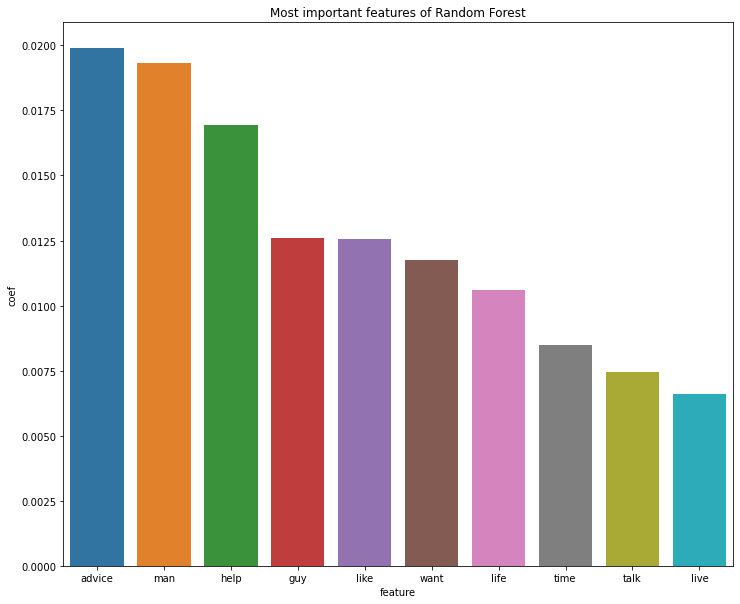

In [959]:
plt.tight_layout()
plt.figure(figsize=(12,10))
sns.barplot(x=ran_for_features['feature'],y=ran_for_features['coef']).set(title="Most important features of Random Forest")
plt.savefig('../resources/features_Random_forest.png')



----
### AdaBoost

In [829]:

predicted_ada=get_df_pred(ada_grid)
predicted_ada_mismatch=predicted_ada[predicted_ada["real"]!=predicted_ada["predicted"]]
predicted_ada_mismatch.head(10)


,index,comment,real,predicted
2,3752,kind doubt hard time know anxiety anxiety bad,0,1
10,1606,I lot post site nut immediately feel ashamed kind thing watch feel regret shame wrong,1,0
15,2745,favorite office place workplace lifehack help,0,1
16,3352,kind embarrassing young randomly decide shave small section belly button present self annoyance blonde fine hair noticeable hair grow dark little thick long pluck recently hair ingrown hair difficult little painful way deal ideally hair normal possible,0,1
17,1975,I know plan propose married know ring size partner fiancé wife,1,0
21,1033,apparently common thought accord tiktok like ask boyfriend spend day teleportation portal,1,0
23,1752,month ago decide finally jungle pubic hair preferred method scissor cut lot month line hair near area look like mess grow way expect use scissor instead permanently trim forever,1,0
34,1742,I lot people social medium thing like flirt want disappear actually ask question,1,0
39,3261,great female character write great female character,0,1
40,750,I girl boss like handsome married obviously leave job near,1,0


In [830]:
predicted_ada_match=predicted_ada[predicted_ada["real"]==predicted_ada["predicted"]]
predicted_ada_match.head(10)

,index,comment,real,predicted
0,3102,I random pink clot discharge come scared implantation bleed instance pregnancy second stop bad idea come minute later doubt pregnancy precum scared sure period come,0,0
1,1249,I woman post love picnic bookstore date man post want,1,1
3,866,recently talk ex lightly mention probably clue girlfriend actually look like,1,1
4,2522,crazy sexual fantasy,0,0
5,3827,prefer bland food seasoned food,0,0
6,3212,I collect play doll know odd desire play doll,0,0
7,3573,answer,0,0
8,618,drink month ago little drunk start stupid shit life mainly ignore work week begin join work conversation team day begin message slack leave town work week start monday morning office chat forth bit end exchange number share tea member team flirt non stop blatantly state appreciate intimidate I want plan hang week leave utterly confused month feel like elaborate prank happen,1,1
9,1326,kind long bear perspective today start good boss bad mood start unload truck cheer man friday polite way start stupid know feel happy friday okay continue work later start fucking end different different like different different technically point aggravate stick rest day feel kind hurt mean tell different mean way fast forward end day lock store shut light ask lock door yes scream I long hey l...,1,1
11,2975,awkward situation use live dude usually wear bras leave house find constrict uncomfortable wear bras usually soon home thing gay dude long term boyfriend chance perve I worried feel like rude uncomfortable dress properly proper polite worry feel weird bra relatively big boob definitely noticeable wear bra wear sport bras moment tight uncomfy support guy think wear bra wear,0,0


In [873]:
ada_grid.best_estimator_.named_steps


{'tf': TfidfVectorizer(),
 'ada': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                    learning_rate=1.01)}

In [875]:
ada_features=pd.DataFrame(ada_grid.best_estimator_.named_steps.ada.feature_importances_)
ada_features['feature']=ada_grid.best_estimator_.named_steps.tf.get_feature_names_out()
ada_features.columns=['coef',"feature"]
ada_features[ada_features['coef']>0].sort_values(by='coef',ascending=False)

,coef,feature
112,0.02,advice
5770,0.02,start
4429,0.02,period
4446,0.02,perspective
4471,0.02,photo
4476,0.02,physical
4563,0.02,point
4665,0.02,pregnancy
4878,0.02,random
5200,0.02,run


----
### Stacked Model

In [831]:
predicted_stack=get_df_pred(stacked_model)
predicted_stack_mismatch=predicted_stack[predicted_stack["real"]!=predicted_stack["predicted"]]
predicted_stack_mismatch.head(10)

,index,comment,real,predicted
6,3212,I collect play doll know odd desire play doll,0,1
7,3573,answer,0,1
8,618,drink month ago little drunk start stupid shit life mainly ignore work week begin join work conversation team day begin message slack leave town work week start monday morning office chat forth bit end exchange number share tea member team flirt non stop blatantly state appreciate intimidate I want plan hang week leave utterly confused month feel like elaborate prank happen,1,0
15,2745,favorite office place workplace lifehack help,0,1
16,3352,kind embarrassing young randomly decide shave small section belly button present self annoyance blonde fine hair noticeable hair grow dark little thick long pluck recently hair ingrown hair difficult little painful way deal ideally hair normal possible,0,1
17,1975,I know plan propose married know ring size partner fiancé wife,1,0
21,1033,apparently common thought accord tiktok like ask boyfriend spend day teleportation portal,1,0
22,3680,rephrase question deal shitty law,0,1
23,1752,month ago decide finally jungle pubic hair preferred method scissor cut lot month line hair near area look like mess grow way expect use scissor instead permanently trim forever,1,0
24,1648,work progress explanation boss manager letter sure reply amp dear greeting cold monday truly mystified wrong mistake perform duty clean driver desire learn utter incompetence year drive experience preference use google map instead waze wrong turn waze late time long eat breakfast day matter generous help strive equip driver job thank million advance way send driver collect vacuu...,1,0


In [832]:
predicted_atack_match=predicted_stack[predicted_stack["real"]==predicted_stack["predicted"]]
predicted_atack_match.head(10)

,index,comment,real,predicted
0,3102,I random pink clot discharge come scared implantation bleed instance pregnancy second stop bad idea come minute later doubt pregnancy precum scared sure period come,0,0
1,1249,I woman post love picnic bookstore date man post want,1,1
2,3752,kind doubt hard time know anxiety anxiety bad,0,0
3,866,recently talk ex lightly mention probably clue girlfriend actually look like,1,1
4,2522,crazy sexual fantasy,0,0
5,3827,prefer bland food seasoned food,0,0
9,1326,kind long bear perspective today start good boss bad mood start unload truck cheer man friday polite way start stupid know feel happy friday okay continue work later start fucking end different different like different different technically point aggravate stick rest day feel kind hurt mean tell different mean way fast forward end day lock store shut light ask lock door yes scream I long hey l...,1,1
10,1606,I lot post site nut immediately feel ashamed kind thing watch feel regret shame wrong,1,1
11,2975,awkward situation use live dude usually wear bras leave house find constrict uncomfortable wear bras usually soon home thing gay dude long term boyfriend chance perve I worried feel like rude uncomfortable dress properly proper polite worry feel weird bra relatively big boob definitely noticeable wear bra wear sport bras moment tight uncomfy support guy think wear bra wear,0,0
12,1974,guy date month distant texte hit want hang mantain friendship right agree thinking friend text day silly stuff like ask plan day series recommendation personally communicate friend day know appreciate want friendship receive text single day small silly thing force,1,1


In [ ]:

df_comparing=pd.DataFrame(columns=["mcomment","wcomment","score"])
df_comparing
for mcomment in predicted_ada_match["comment"]:
    for wcomment in predicted_ada_mismatch["comment"]:
        mnlp=nlp(mcomment)
        wnlp=nlp(wcomment)
        score=mnlp.similarity(wnlp)
        # if score>0.9:
        print (mcomment, wcomment)
        # temp={"mcomment":mcomment,"wcomment":wcomment,"score":score}
        # df_comparing.append(temp,ignore_index=True)